In [1]:
import csv
from biosppy.signals.tools import get_heart_rate, smoother
import biosppy.signals.bvp as bvp
import biosppy.signals.eda as eda
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from scipy.signal import find_peaks

import sys
sys.path.append("..")
from biodatapy.heart import Heart

# To Do:
- Look at bvp signal
- Play with window size and align with emotions
- provide several resolution to NN
- Amplitude of the heart-rate

In [2]:
# Utility function to filter the signal by computing the envelope of the signal
def enveloppe_filter(x, threshold=1e-2):
    for i in range(1, len(x)):
        mask = x[i] <= threshold
        x[i] = x[i-1]*mask + x[i]*(1-mask)
    return x

def rate_of_change(x, size=1):
    rate = [0]*size
    for i in range(size, len(x)-size):
        r = (x[i+size]-x[i-size])/(2*size)
        rate.append(r)
    rate += [0]*size
    assert len(rate)==len(x)
    return np.array(rate)
        
def compute_intervals(peaks):
    intervals = []
    for i in range(len(peaks)-1):
        intervals.append(peaks[i+1]-peaks[i])
    return np.array(intervals)

# Utility class to simulate a data stream from array
class DataStream:
    def __init__(self, data, sampling_rate: int = 1000):
        self.data = data
        self.i = 0
        self.ms = 0
        self.sampling_rate = sampling_rate
        
    def reset(self) -> None:
        self.i = 0
        self.ms = 0
        
    def read(self) -> None:
        data = self.data[self.i]
        self.ms += 1/self.sampling_rate*1000
        self.i += 1
        return (data, self.ms)

    def hasNext(self) -> bool:
        if self.i < len(self.data):
            return True
        else:
            return False
        
    def __len__(self) -> int:
        return len(self.data)
    
def plot_emotions(height):
    LIST_INTERVALS = [0, 300000, 611000, 783000, 1004000, 1054000, 1211000, 1381000, 1500000]
    for i in range(len(LIST_INTERVALS)-1):
        plt.axvline(LIST_INTERVALS[i], color="red")
        x = LIST_INTERVALS[i] + (LIST_INTERVALS[i+1]-LIST_INTERVALS[i])/2
        plt.text(x, height ,str(i))

In [3]:
# Load data
filename = "/checkpoint/hberard/crocodile/LaurenceHBS-Nov919mins1000Hz-Heart+GSR-2channels.csv"
signals = np.loadtxt(filename, delimiter=',', max_rows=None)

# Processing Heart Data

In [4]:
# Extracting raw signal and filtering
signals_clean = enveloppe_filter(signals)

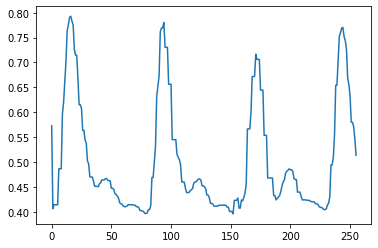

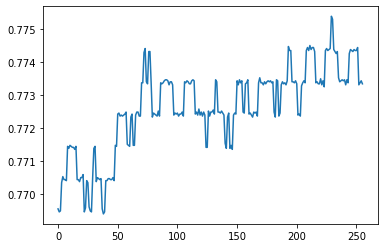

In [44]:
plt.figure()
gsr = signals_clean[::10, 1]
plt.plot(gsr[:256])
plt.figure()
gsr = signals_clean[::50, 2]
start = 300
plt.plot(gsr[start:start+256])

In [47]:
print(t[:10])

[0.00760278 0.00836306 0.00912333 0.00988361 0.01064389 0.01140417
 0.01216444 0.01292472 0.013685   0.01444528]


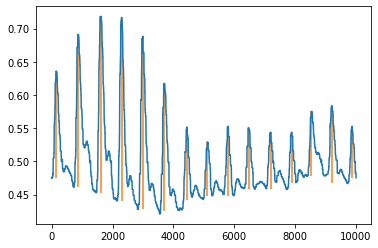

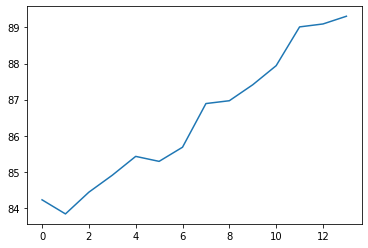

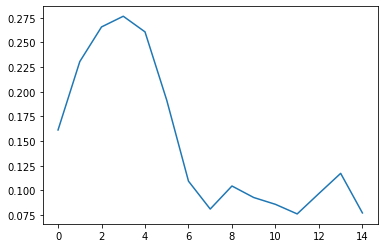

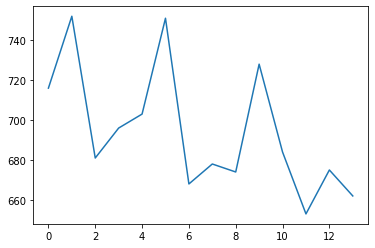

In [97]:
# Sanity check to see if peak detection works correctly
start = 10
window_size = 10000
distance = 400
width = 100
prominence = 0.01
smoothing = True
size = 10

data = bvp_raw[start*window_size:(start+1)*window_size]
data_stream = DataStream(data)

peaks, properties = find_peaks(data, distance=distance, width=width, prominence=prominence)
#print(peaks, properties)
bpm = get_heart_rate(peaks, sampling_rate=1000, smooth=smoothing, size=size)
intervals = compute_intervals(peaks)

plt.figure()
plt.plot(data)
plt.vlines(x=peaks, ymin=data[peaks] - properties["prominences"], ymax = data[peaks], color = "C1")
plt.figure()
plt.plot(bpm[1])
plt.figure()
plt.plot(properties["prominences"])
plt.figure()
plt.plot(intervals)

[    938    1710    2437 ... 1497140 1497919 1498721]
2066 2076


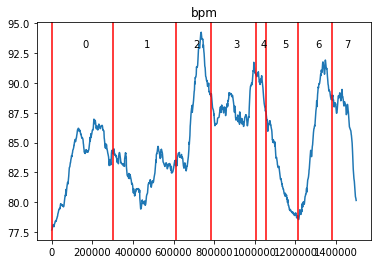

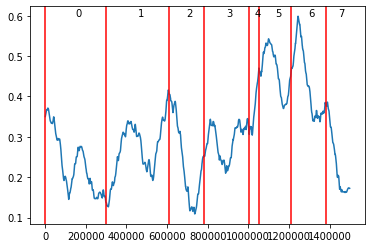

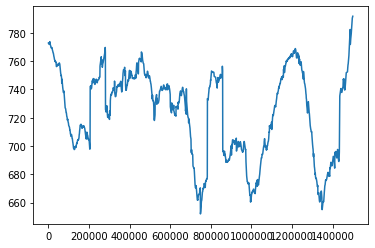

In [112]:
# Compute bpm for the whole data
size = 100
smoothing = True
peaks, properties = find_peaks(bvp_raw, distance=distance, width=width, prominence=prominence)
bpm = get_heart_rate(peaks, sampling_rate=1000, smooth=smoothing, size=size)
intervals = compute_intervals(peaks)
amplitudes = properties["prominences"]
if smoothing:
    intervals, _ = smoother(signal=intervals, kernel='boxcar', size=size, mirror=True)
    amplitudes, _ = smoother(signal=amplitudes, kernel='boxcar', size=size, mirror=True)
    
print(bpm[0])
print(len(bpm[1]), len(peaks))
plt.figure()
plt.plot(bpm[0], bpm[1])
plot_emotions(93)
plt.title("bpm")
plt.figure()
plt.plot(bpm[0], amplitudes[5:-5])
plot_emotions(0.6)
plt.figure()
plt.plot(bpm[0], intervals[5:-4])
#plot_emotions(6000)

# Processing Sweat Data

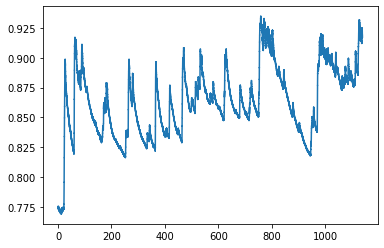

In [41]:
# Extracting raw signal and filtering
t = signals[:,0][10:]
eda_raw = signals[:,2]
eda_raw = enveloppe_filter(eda_raw)[10:]
plt.figure()
plt.plot(t, eda_raw)

In [46]:
print(t[:10])

[0.00760278 0.00836306 0.00912333 0.00988361 0.01064389 0.01140417
 0.01216444 0.01292472 0.013685   0.01444528]


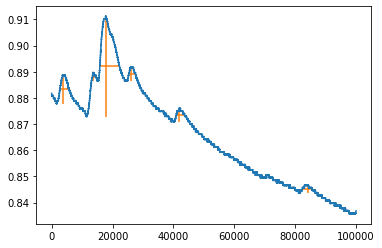

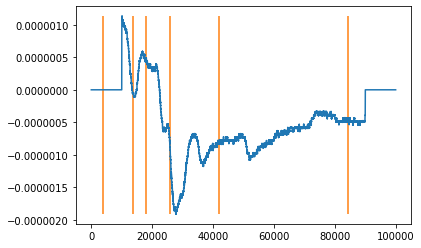

In [93]:
# Sanity check to see if peak detection works correctly
start = 1
window_size = 100000
width = 600
distance = 1800
prominence = 0.0014
size = 10000

data = eda_raw[start*window_size:(start+1)*window_size]
peaks, properties = find_peaks(data, width=width, distance=distance, prominence=prominence)
plt.figure()
plt.plot(data)
plt.vlines(x=peaks, ymin=data[peaks] - properties["prominences"], ymax = data[peaks], color = "C1")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"], xmax=properties["right_ips"], color = "C1")

rate = rate_of_change(data, size=size)
plt.figure()
plt.plot(rate)
plt.vlines(x=peaks, ymin=rate.min(), ymax=rate.max(), color = "C1")

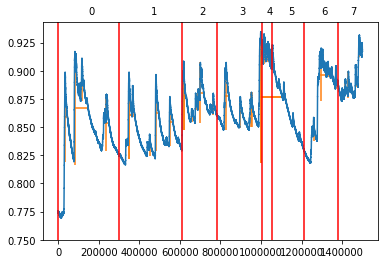

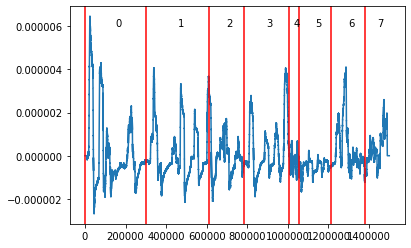

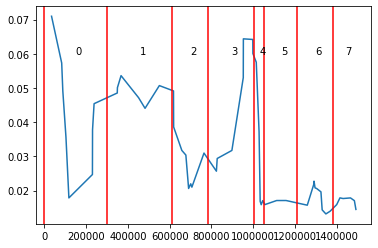

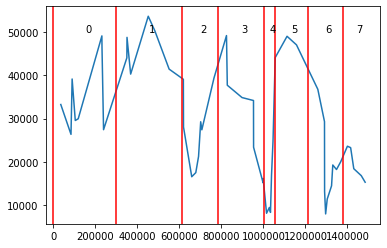

In [150]:
# Compute bpm for the whole data
smoothing = True
size = 5
peaks, properties = find_peaks(eda_raw, width=width, distance=distance, prominence=prominence)

intervals = compute_intervals(peaks)
amplitudes = properties["prominences"]
if smoothing:
    intervals, _ = smoother(signal=intervals, kernel='boxcar', size=size, mirror=True)
    amplitudes, _ = smoother(signal=amplitudes, kernel='boxcar', size=size, mirror=True)

rate = rate_of_change(eda_raw, size=10000)

plt.figure()
plt.plot(eda_raw)
plt.vlines(x=peaks, ymin=eda_raw[peaks] - properties["prominences"], ymax = eda_raw[peaks], color = "C1")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"], xmax=properties["right_ips"], color = "C1")
plt.ylim(bottom=0.75)
plot_emotions(0.950)

plt.figure()
plt.plot(rate)
plot_emotions(0.000006)
#plt.vlines(x=peaks, ymin=rate.min(), ymax=rate.max(), color = "C1")

plt.figure()
plt.plot(peaks, amplitudes)
plot_emotions(0.06)

plt.figure()
plt.plot(peaks[:-1], intervals)
plot_emotions(50000)



# Old Draft

<IPython.core.display.Javascript object>


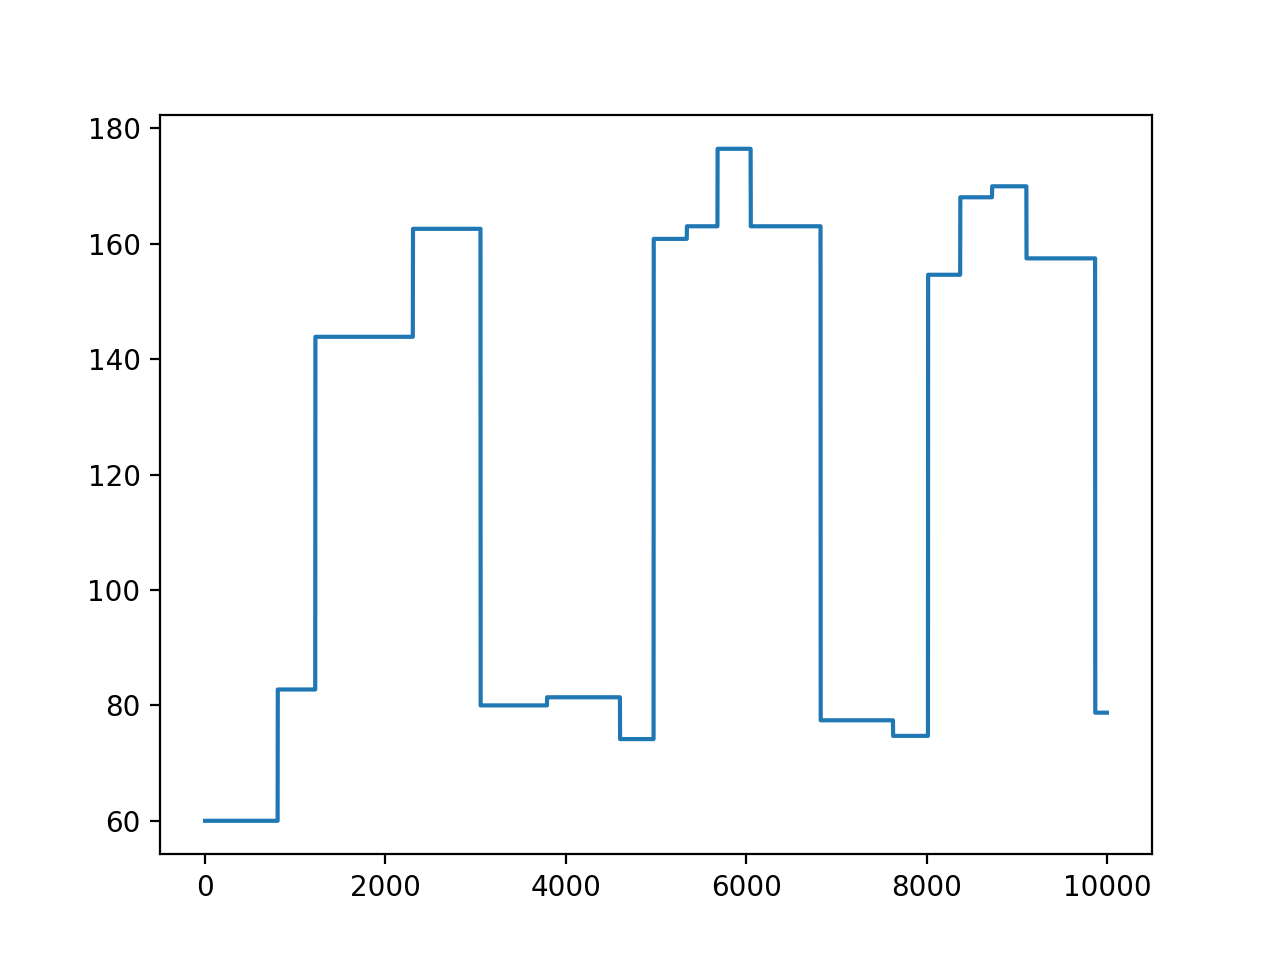

<IPython.core.display.Javascript object>


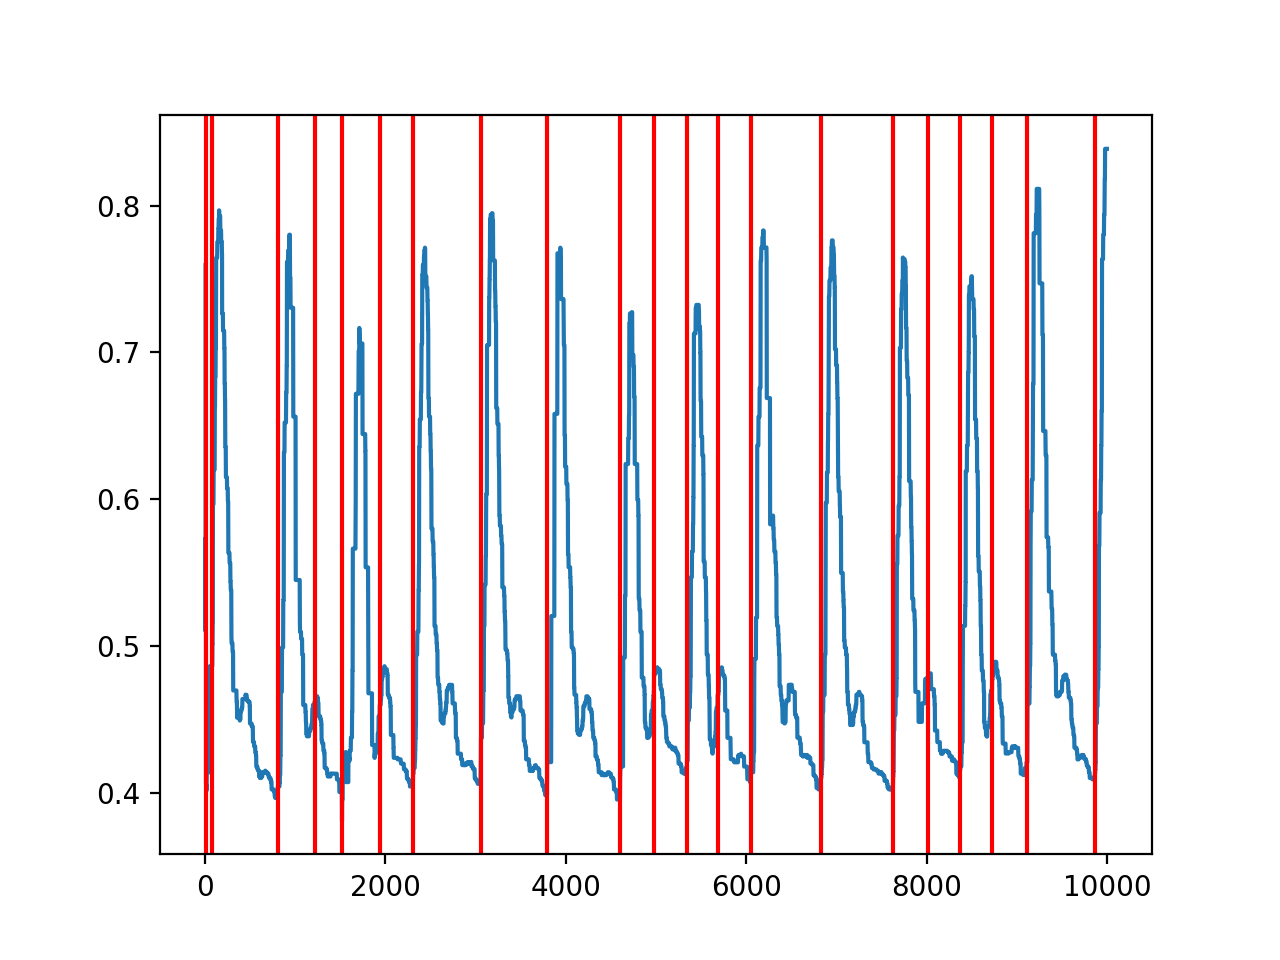

In [21]:
plt.figure()
plt.plot(bpm)
plt.figure()
plt.plot(data)
for p in peaks:
    plt.axvline(x=p, color="red")

In [19]:
bpm = []
peaks = []
data_stream.reset()
heart.reset()
t = tqdm.tqdm(total=len(data_stream))
while data_stream.hasNext():
    heart.update()
    bpm.append(heart.getBPM())
    if heart.beat:
        peaks.append(data_stream.i)
    t.update()
#plt.figure()
#plt.plot(bpm)





  0%|          | 0/10000 [00:00<?, ?it/s]



 14%|█▍        | 1450/10000 [00:00<00:00, 14499.12it/s]



 31%|███▏      | 3143/10000 [00:00<00:00, 15150.36it/s]



 48%|████▊     | 4788/10000 [00:00<00:00, 15517.06it/s]



 66%|██████▌   | 6569/10000 [00:00<00:00, 16140.16it/s]



 84%|████████▎ | 8361/10000 [00:00<00:00, 16634.03it/s]

0 91.36567574423589 27.963134070298473 167.06178433557625 48.47187976971598
1 86.4122238628553 22.13792246164303 174.76926821416936 43.157232696999046
2 99.87782102690699 28.166845668204775 188.72577886441746 49.600639580049325
3 91.19471747939987 25.664803632780835 180.83528493364557 41.251298652861095
4 79.26850233488189 19.60606086980825 128.80039704629928 45.371063286932504
5 92.96846489558 23.366972545931294 153.53772496575456 48.118994671428524
6 89.32906813520668 22.28745047042183 172.75894486534312 51.42220806939261
7 85.11940032986234 19.100313541203 146.54522378588226 56.69859960003638


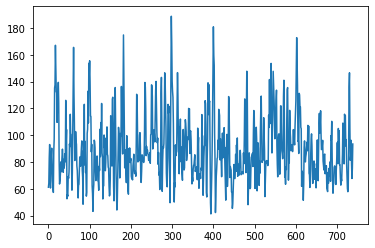

In [28]:
intervals = [0, 300000, 611000, 783000, 1004000, 1054000, 1211000, 1381000, -1] 
for i in range(len(intervals)-1):
    start_time = bvp_signal[0][intervals[i]]
    end_time = bvp_signal[0][intervals[i+1]]
    
    mask =  np.logical_and(start_time <= bvp_signal[3], bvp_signal[3] <= end_time)
    signal = bvp_signal[4][mask]
    mean = signal.mean()
    std = signal.std()
    print(i, mean, std, signal.max(), signal.min())
    
plt.figure()
plt.plot(bvp_signal[4])

(1499452, 3)


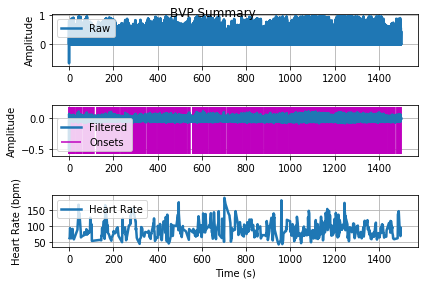

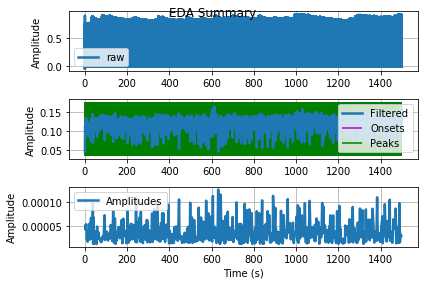

In [36]:
# This is broken !
sampling_rate = 1000
min_amplitude = 0.1
print(signals.shape)
t = signals[:,0]
bvp_raw = signals[:,1]
eda_raw = signals[:,2]

bvp_signal = bvp.bvp(bvp_raw, sampling_rate=sampling_rate)
eda_signal = eda.eda(eda_raw, sampling_rate=sampling_rate, min_amplitude=min_amplitude)

0 3.5785178601031196 1.7726173722164287 10.805710024553518 1.2734876433297264
1 3.665426139086279 2.15415911102666 11.243946392239307 1.3985124959390112
2 3.7618897859638696 2.366425456758715 12.57306211980875 1.2930250303773005
3 3.767224635726514 2.0855803211960056 11.266490084683793 1.263277901883984
4 4.263630023565308 2.39979271082286 9.757770116452141 1.396712819756155
5 3.7901524609925663 2.0242265324162747 10.231666158276816 1.291870460592724
6 3.513107509386987 1.9150238506360442 8.969685690700196 1.3059418386224897
7 4.151707761268728 2.46638215161853 10.966923173694648 1.4297145760155725


<IPython.core.display.Javascript object>


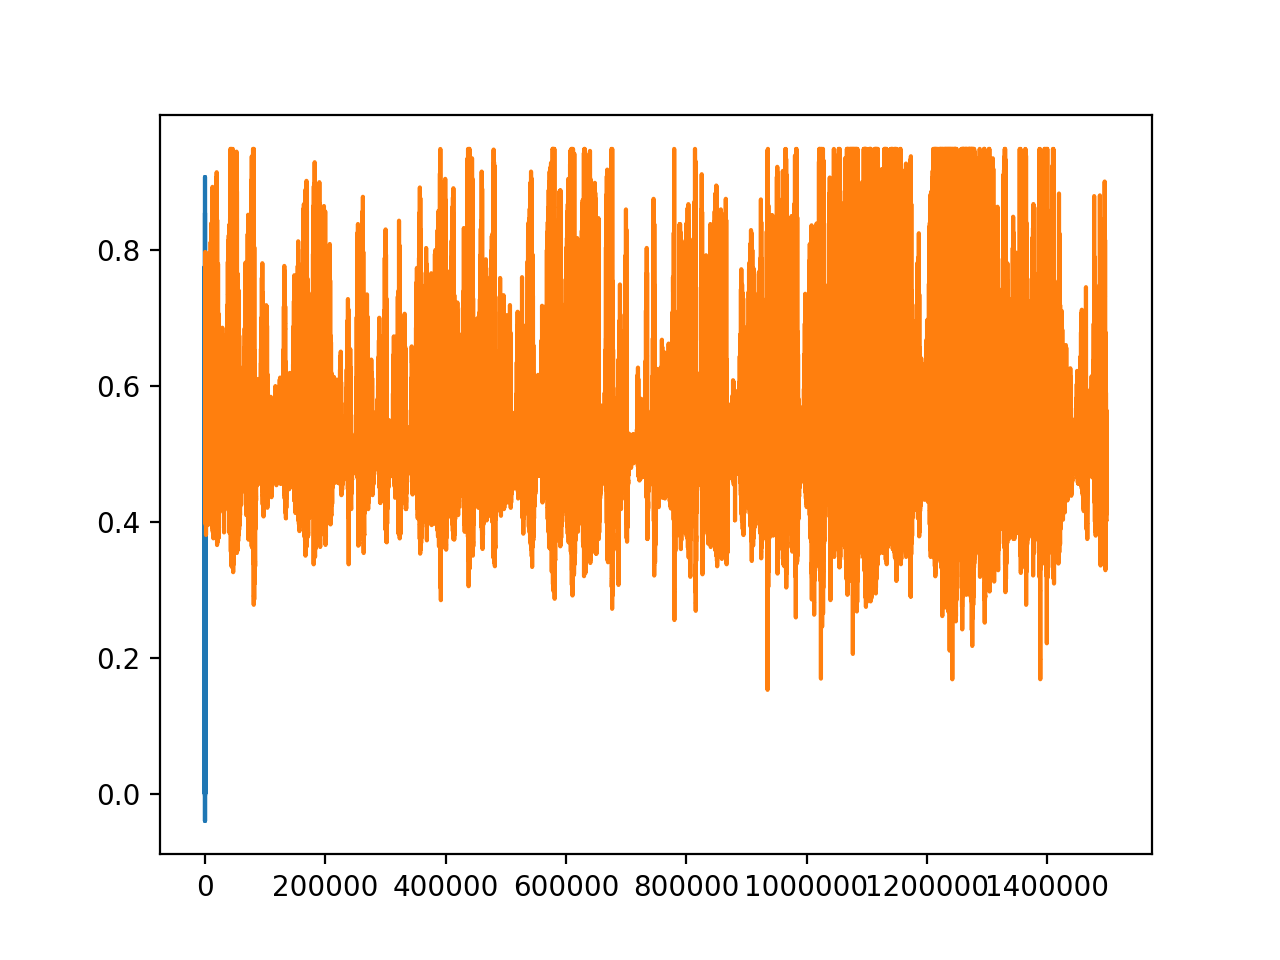

In [50]:
intervals = [0, 300000, 611000, 783000, 1004000, 1054000, 1211000, 1381000, 1505000] 
for i in range(len(intervals)-1):
    mask =  np.logical_and(intervals[i] <= eda_signal[3], eda_signal[3] <= intervals[i+1])
    signal = eda_signal[4][mask]*1e5
    mean = signal.mean()
    std = signal.std()
    print(i, mean, std, signal.max(), signal.min())
    

plt.figure()
plt.plot(eda_signal[0][:100], eda_raw[:100])

<IPython.core.display.Javascript object>


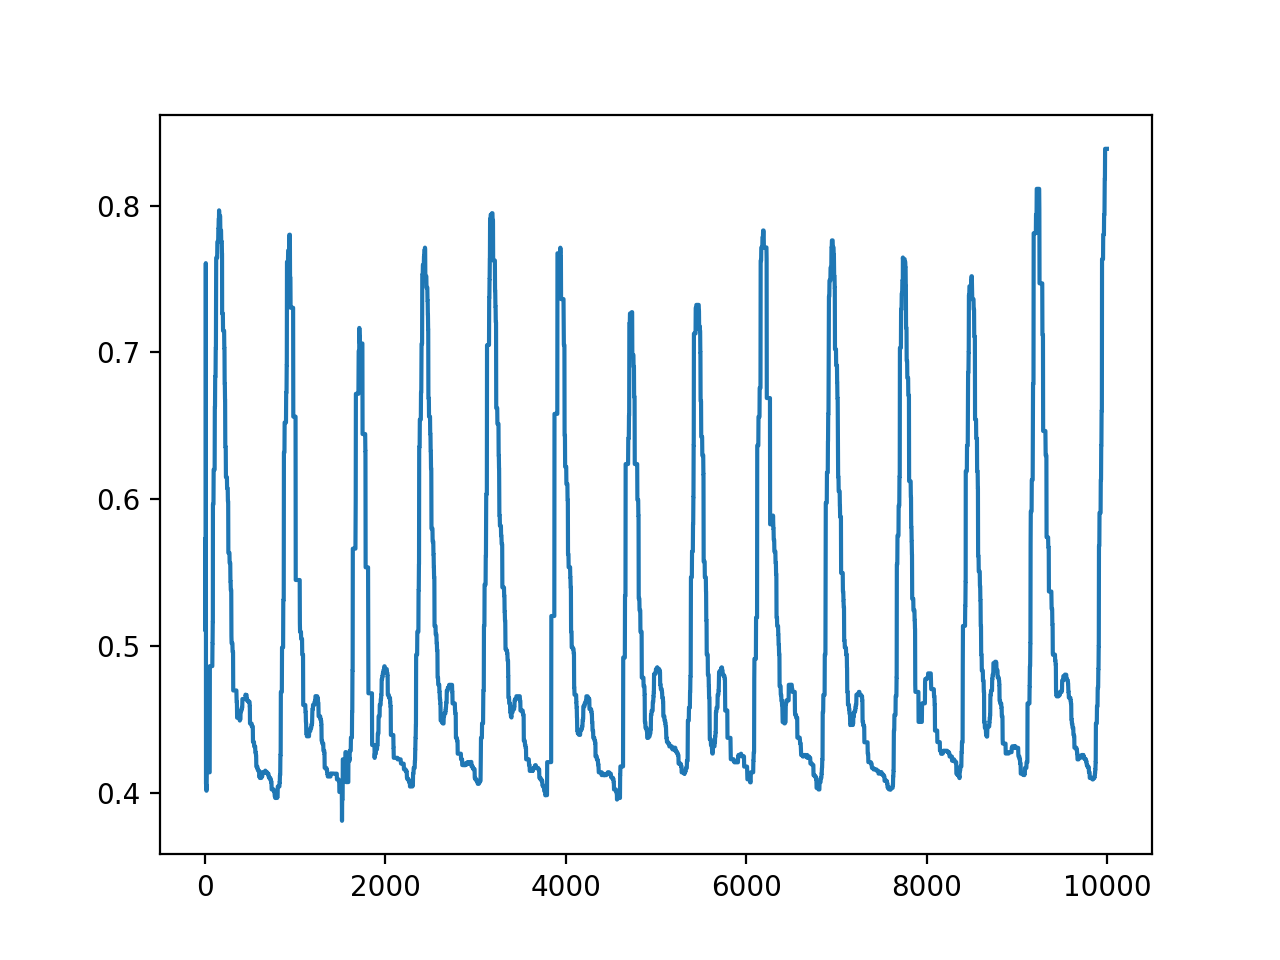

In [111]:
plt.figure()
plt.plot(filtered_bvp[:10000])

In [102]:
filtered_eda = enveloppe_filter(eda_raw)[20:]

<IPython.core.display.Javascript object>


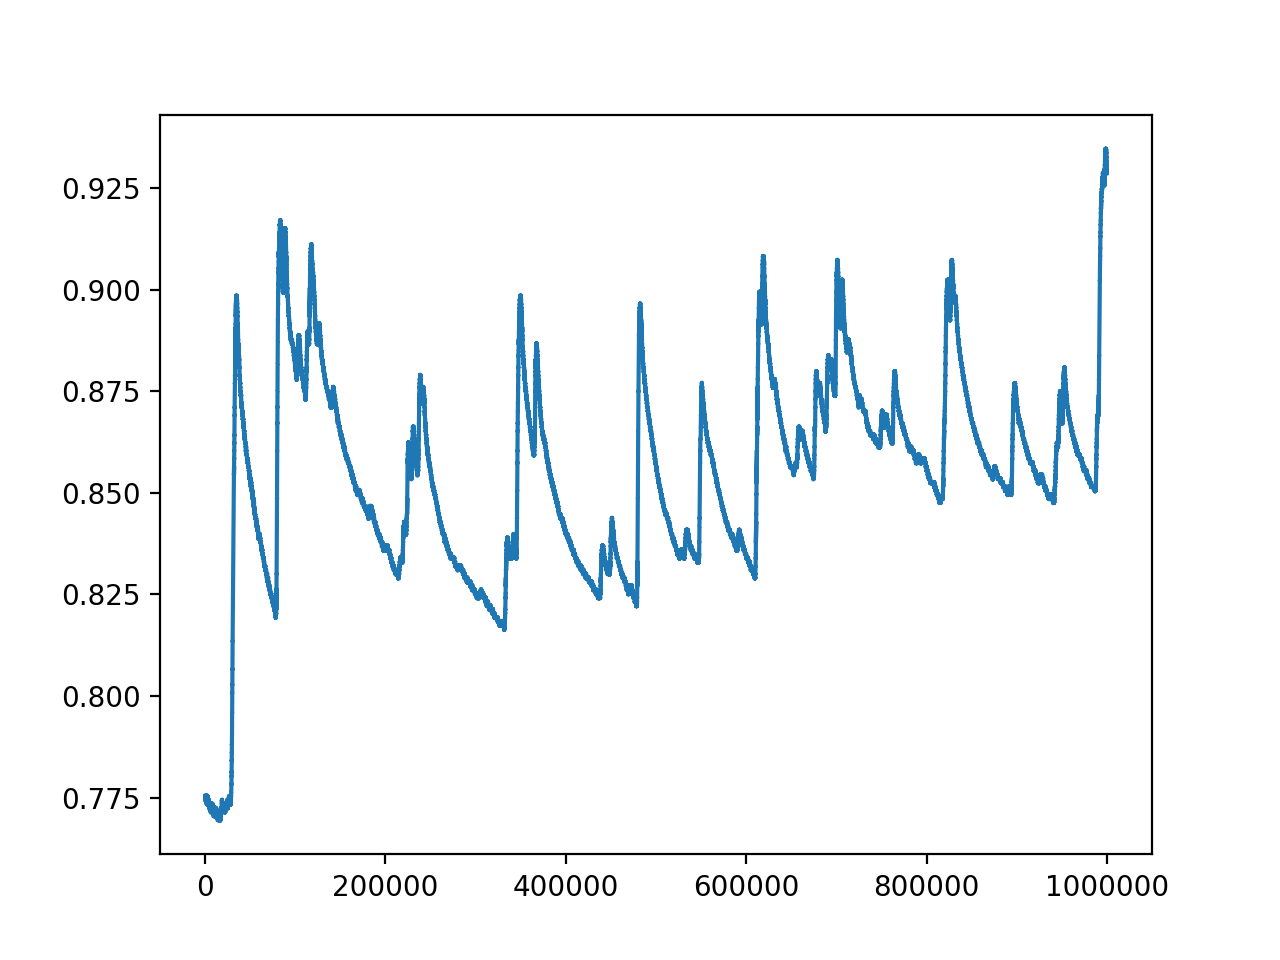

In [122]:
plt.figure()
plt.plot(filtered_eda[:1000000])

<IPython.core.display.Javascript object>


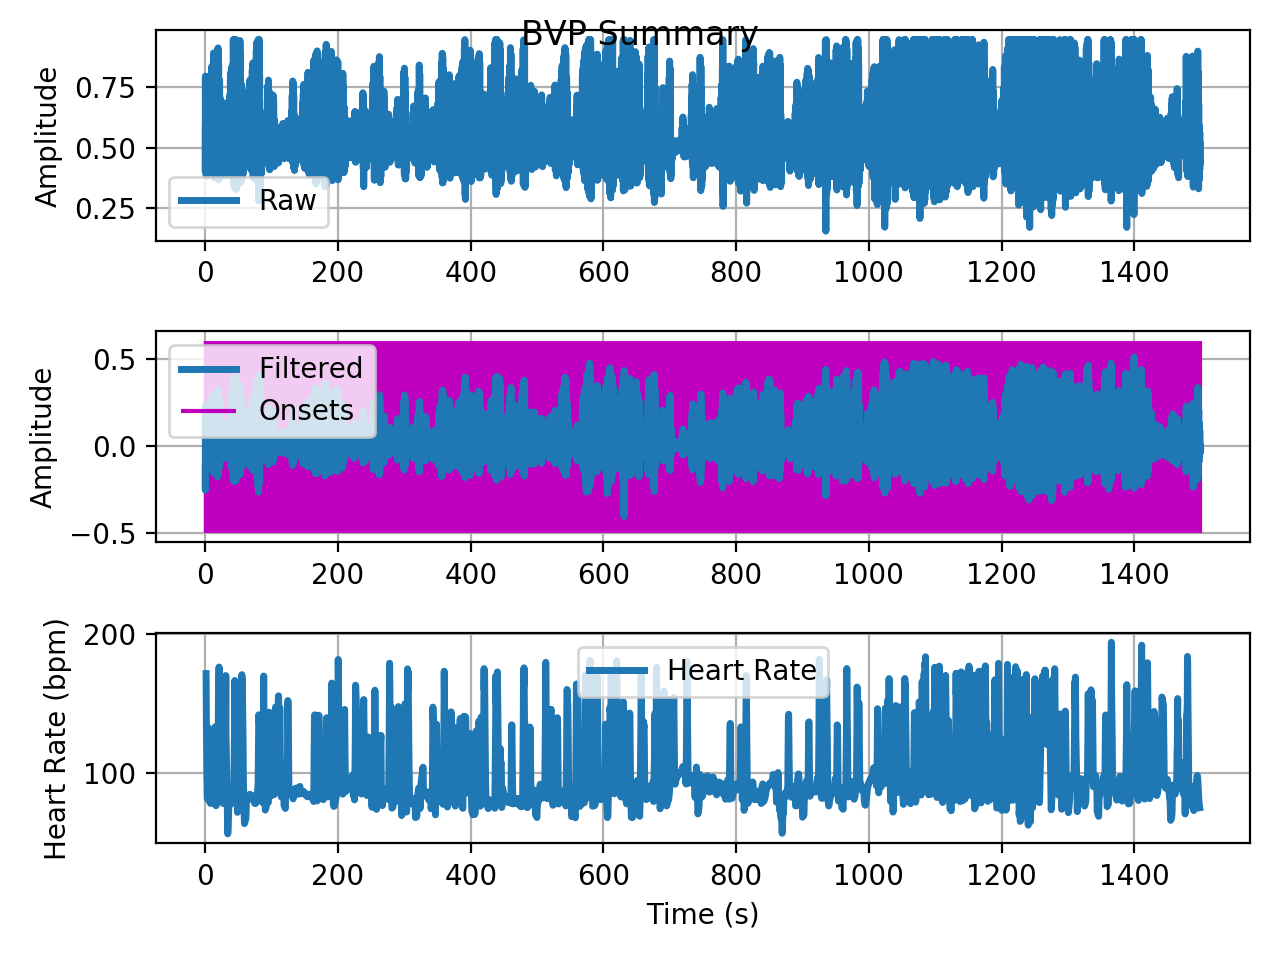

In [114]:
bvp_signal = bvp.bvp(filtered_bvp[:-1], sampling_rate=sampling_rate)

#eda_signal = eda.eda(filtered_eda, sampling_rate=sampling_rate, min_amplitude=min_amplitude)

(1499432,) 0.769287109375
(1499452,)


<IPython.core.display.Javascript object>


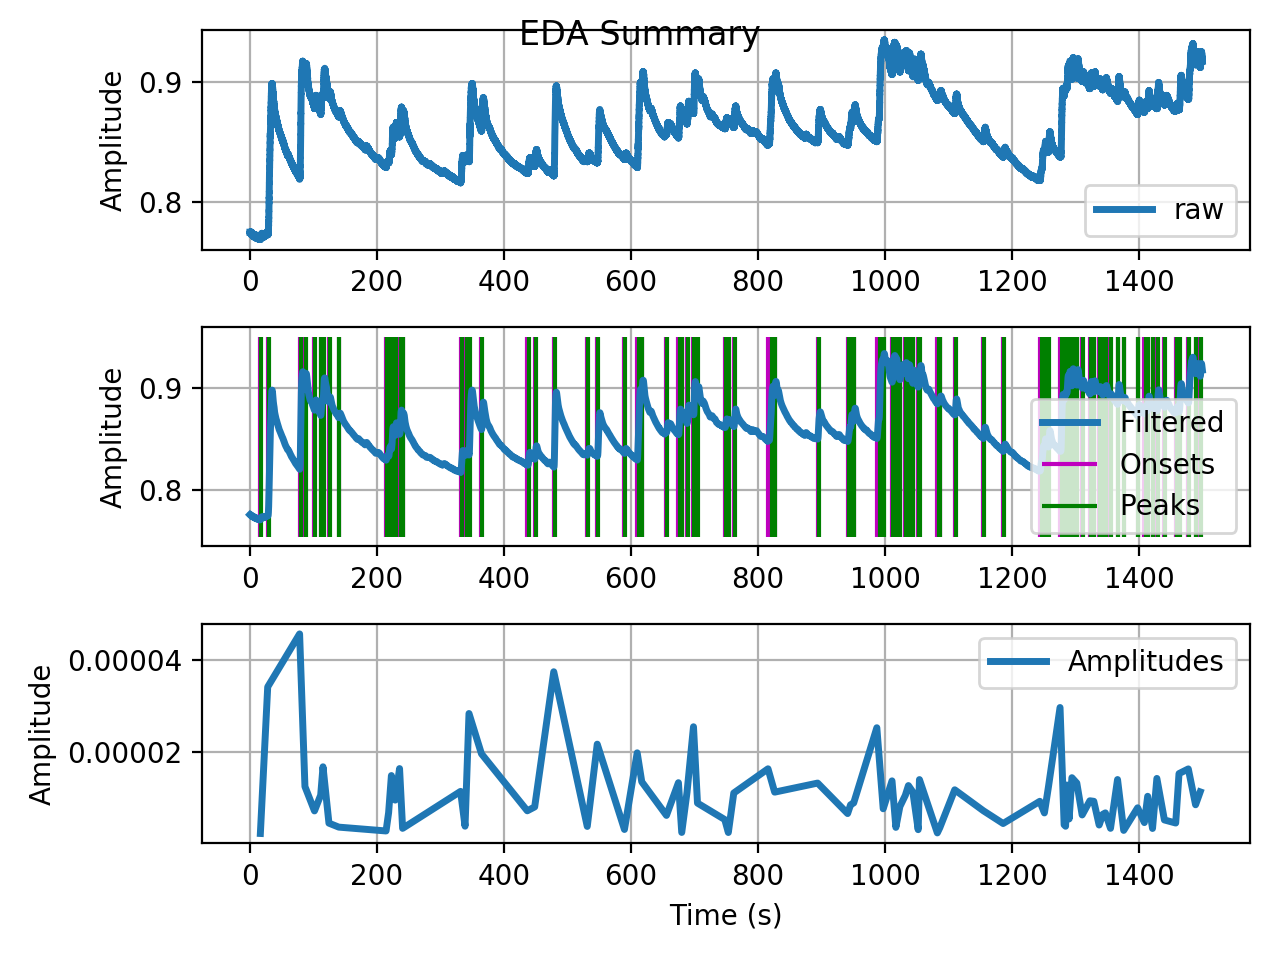

In [107]:
print(filtered_eda.shape, filtered_eda.min())
print(eda_raw.shape)
eda_signal = eda.eda(filtered_eda, sampling_rate=1000, min_amplitude=0.05)

In [108]:
intervals = [0, 300000, 611000, 783000, 1004000, 1054000, 1211000, 1381000, -1]
for i in range(len(intervals)-1):
    start_time = bvp_signal[0][intervals[i]]
    end_time = bvp_signal[0][intervals[i+1]]
    
    mask =  np.logical_and(start_time <= bvp_signal[3], bvp_signal[3] <= end_time)
    signal = bvp_signal[4][mask]
    mean = signal.mean()
    std = signal.std()
    print(i, mean, std, signal.max(), signal.min())

0 101.27088352938462 26.6266549992748 181.60538197223494 56.09627958011256
1 101.39130478667643 29.33674802164093 180.93788061839177 65.98404523478214
2 101.58525053546256 24.656927135717254 180.5983055836948 67.72677390864511
3 94.11682514655374 19.964625895229013 181.84958121060356 56.48043022783865
4 108.80647481598778 22.938186613107412 167.83930932284613 71.73825478345039
5 115.21192943409302 33.27928338259362 183.57347862396932 72.73516350502538
6 114.05654906148347 31.675351945992915 176.4518761323873 60.76692046355905
7 101.97947982679452 25.194965089182553 183.7936180099581 65.82542880945999


In [117]:
hr = get_heart_rate(filtered_bvp, sampling_rate=sampling_rate)

/opt/miniconda3/lib/python3.7/site-packages/biosppy/signals/tools.py:1435: RuntimeWarning: divide by zero encountered in true_divide
  hr = sampling_rate * (60. / np.diff(beats))


In [122]:
def test(x=3):
    print(x)

test(**[dict(x=1), dict(x=2)][1])

2
